In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE
from src.utils import audio_to_spectrogram

In [2]:
DAFX_TO_USE = [
    'mda Overdrive',
    'mda Delay',
    'mda RingMod',
    'mda Dynamics',
    'mda Combo',
    'mda Ambience',
    'mda Thru-Zero Flanger'
]

In [3]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 2_000
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/qmd5xzc9/checkpoints/epoch=1320-step=825625.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def dafx_from_name(dafx_name):
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [6]:
def get_dataset(dafx):
    dataset = PairedAudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES,
        augmentations={},
        length=131_072,
        effect_input=False,
        effect_output=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [7]:
latent_embeddings = dict()

In [8]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT).to(device)
model.eval()
beta = str(model.hparams.vae_beta).replace(".", "p")

In [10]:
from tqdm import tqdm

mu_running = []
log_var_running = []

for fx in DAFX_TO_USE:
    dafx = dafx_from_name(fx)
    dataset = get_dataset(dafx)

    embeddings = []

    for batch in tqdm(dataset):
        x, y = batch
        x_s = audio_to_spectrogram(signal=x)
        y_s = audio_to_spectrogram(signal=y)

        X = torch.concat([x_s, y_s], dim=1).to(device)

        x_hat, mu, log_var, z = model(X)

        embeddings.append(z.cpu().detach().numpy())
        mu_running.append(mu.cpu().detach().numpy())
        log_var_running.append(log_var.cpu().detach().numpy())

    latent_embeddings[fx] = np.array(embeddings)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 36111.80it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 28422.82it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 40123.79it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 38208.98it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 43582.33it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 38451.79it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 40285.83it/s]



Loaded 88 files for train = 66.89 hours.


100%|██████████| 2000/2000 [01:08<00:00, 29.12it/s] 


In [11]:
def kl_loss(mean, log_variance):
    kld_batch = -0.5 * torch.sum(1 + log_variance - torch.square(mean) - torch.exp(log_variance))
    kld = kld_batch / (mean.size()[0] * mean.size()[1])
    return kld

In [12]:
log_var_tensor = torch.tensor(np.array(log_var_running)).squeeze()

In [13]:
mu_tensor = torch.tensor(np.array(mu_running)).squeeze()

In [14]:
kl_loss(mu_tensor, log_var_tensor)

tensor(0.3750)

In [15]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [16]:
import umap

In [17]:
reducer = umap.UMAP().fit(data)

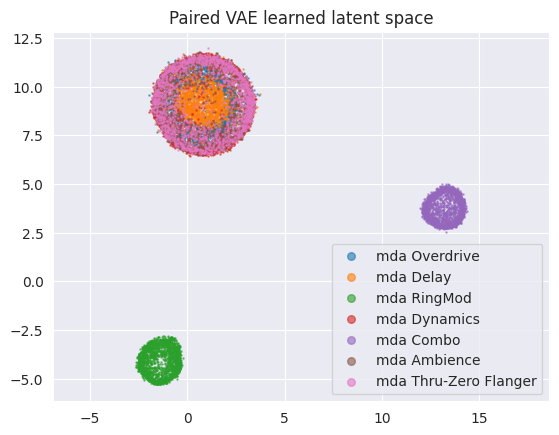

In [18]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.6, s=0.6)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"Paired VAE learned latent space")

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

plt.savefig(f"./figures/latent_analysis/{CHECKPOINT_ID}_{len(DAFX_TO_USE)}dafx_latent_beta{beta}.png")